In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [3]:
#Reading data and creating the ratings matrix
df = pd.read_csv('C:/Users/nevin/Downloads/Georgia Tech/Courses/DMSL_7406/Project/ml-latest-small/ratings.csv')

In [4]:
# Filter sparse movies
min_movie_ratings = 10
filter_movies = (df['movieId'].value_counts()>min_movie_ratings)
filter_movies = filter_movies[filter_movies].index.tolist()

# Filter sparse users
min_user_ratings = 10
filter_users = (df['userId'].value_counts()>min_user_ratings)
filter_users = filter_users[filter_users].index.tolist()

df = df[(df['movieId'].isin(filter_movies)) & (df['userId'].isin(filter_users))]
del filter_movies, filter_users, min_movie_ratings, min_user_ratings

In [5]:
# Shuffle DataFrame
df = df.drop('timestamp', axis=1).sample(frac=1).reset_index(drop=True)
df.head()

,userId,movieId,rating
0,604,610,5.0
1,288,260,5.0
2,600,1077,3.5
3,608,3081,4.0
4,484,367,3.0


In [6]:
from sklearn.model_selection import train_test_split
df_train , df_test = train_test_split(df, test_size = 0.2)

In [7]:
#Creating the training ratings matrix
ratings = pd.pivot_table(df_train, index = 'userId', columns = 'movieId', values = 'rating')

#Scaling
min_rating, max_rating = df['rating'].min(), df['rating'].max()
ratings = (ratings - min_rating) / (max_rating - min_rating)

ratings[ratings.isnull()] = -1
ratings = torch.FloatTensor(ratings.values)
ratings = ratings.to(device)

#Generating the test ratings matrix
rate2 = pd.pivot_table(df, index = 'userId', columns = 'movieId', values = 'rating')
rate2 = torch.FloatTensor(rate2.values)
rate2 = rate2.to(device)

rate = pd.pivot_table(df_train, index = 'userId', columns = 'movieId', values = 'rating')
rate[rate.isnull()] = -1
rate[rate >= 0] = np.nan
rate = rate + 1
rate = torch.FloatTensor(rate.values)
rate = rate.to(device)

test = rate2 - rate
test[torch.isnan(test)] = -1

del rate, rate2

n_users, n_movies = ratings.shape

In [8]:
#Instead of returning the prediction, this returns the loss directly in the forward prop
class PMFLoss(torch.nn.Module):
    def __init__(self, lam_u=0.3, lam_v=0.3):
        super().__init__()
        self.lam_u = lam_u
        self.lam_v = lam_v
    
    def forward(self, matrix, u_features, v_features):
        non_zero_mask = (matrix != -1).type(torch.FloatTensor).to(device)
        predicted = torch.sigmoid(torch.mm(u_features, v_features.t())).to(device)
        
        diff = ((matrix - predicted)**2).to(device)
        prediction_error = torch.sum(diff*non_zero_mask).to(device)

        u_regularization = self.lam_u * torch.sum(u_features.norm(dim=1)**2)
        v_regularization = self.lam_v * torch.sum(v_features.norm(dim=1)**2)
        
        return prediction_error + u_regularization + v_regularization

## Analyzing the impact of the number of latent features on the test RMSE

In [9]:
non_zero_mask_train = (ratings != -1).type(torch.FloatTensor).to(device)
non_zero_mask_test = (test != -1).type(torch.FloatTensor).to(device)
ratings_org = ratings*(max_rating - min_rating) + min_rating
D_list = [5,25,50]
lam = 0.45
results = pd.DataFrame()

In [10]:
for D in D_list:
    lam_u, lam_v = lam, lam
    latent_vectors = D
    user_features = torch.randn(n_users, latent_vectors, requires_grad=True, device = device)
    user_features.data.mul_(0.01)
    movie_features = torch.randn(n_movies, latent_vectors, requires_grad=True, device = device)
    movie_features.data.mul_(0.01)
    PMF_model = PMFLoss(lam_u, lam_v)
    optimizer = torch.optim.Adam([user_features, movie_features], lr=0.01)
    rmse_train = []
    rmse_test = []
    for step, epoch in enumerate(range(2000)):
        optimizer.zero_grad()
        loss = PMF_model(ratings, user_features, movie_features)
        loss.backward()
        optimizer.step()

        predicted = torch.sigmoid(torch.mm(user_features, movie_features.t())).to(device)
        predicted = (predicted*(max_rating - min_rating) + min_rating)
        train_err = torch.sqrt(torch.sum(((predicted - ratings_org) ** 2) * non_zero_mask_train)/len(df_train))
        rmse_train.append(train_err.item())
        test_err = torch.sqrt(torch.sum(((predicted - test) ** 2) * non_zero_mask_test)/len(df_test))
        rmse_test.append(test_err.item())

    results[str(D) + '_train'] = rmse_train
    results[str(D) + '_test'] = rmse_test

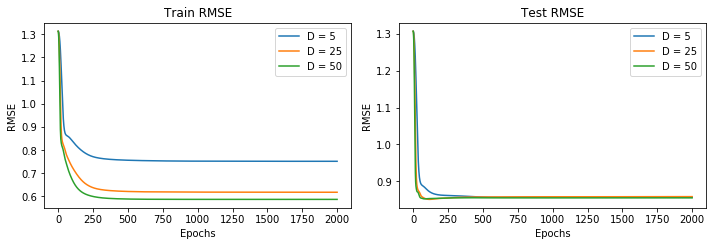

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,3.5))
ax1.plot(results.iloc[:,0], label='D = 5')
ax1.plot(results.iloc[:,2], label='D = 25')
ax1.plot(results.iloc[:,4], label='D = 50')
ax1.set_title('Train RMSE')
ax1.set(xlabel='Epochs', ylabel='RMSE')
ax1.legend()
ax2.plot(results.iloc[:,1], label='D = 5')
ax2.plot(results.iloc[:,3], label='D = 25')
ax2.plot(results.iloc[:,5], label='D = 50')

ax2.set_title('Test RMSE')
ax2.set(xlabel='Epochs', ylabel='RMSE')
ax2.legend()

fig.tight_layout(pad=1.0)

## Analyzing the effect of $\lambda$ on the test RMSE

In [12]:
D = 25
lam_list = [0.1,0.2,0.4,0.8]
results = pd.DataFrame()

for lam in lam_list:
    lam_u, lam_v = lam, lam
    latent_vectors = D
    user_features = torch.randn(n_users, latent_vectors, requires_grad=True, device = device)
    user_features.data.mul_(0.01)
    movie_features = torch.randn(n_movies, latent_vectors, requires_grad=True, device = device)
    movie_features.data.mul_(0.01)
    PMF_model = PMFLoss(lam_u, lam_v)
    optimizer = torch.optim.Adam([user_features, movie_features], lr=0.01)
    rmse_train = []
    rmse_test = []
    for step, epoch in enumerate(range(2000)):
        optimizer.zero_grad()
        loss = PMF_model(ratings, user_features, movie_features)
        loss.backward()
        optimizer.step()

        predicted = torch.sigmoid(torch.mm(user_features, movie_features.t())).to(device)
        predicted = (predicted*(max_rating - min_rating) + min_rating)
        train_err = torch.sqrt(torch.sum(((predicted - ratings_org) ** 2) * non_zero_mask_train)/len(df_train))
        rmse_train.append(train_err.item())
        test_err = torch.sqrt(torch.sum(((predicted - test) ** 2) * non_zero_mask_test)/len(df_test))
        rmse_test.append(test_err.item())

    results[str(lam) + '_train'] = rmse_train
    results[str(lam) + '_test'] = rmse_test
    

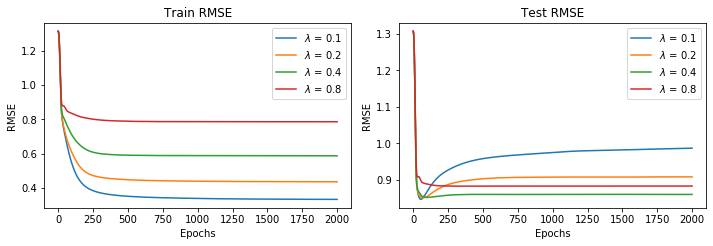

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,3.5))
ax1.plot(results.iloc[:,0], label=r'$\lambda$ = 0.1')
ax1.plot(results.iloc[:,2], label=r'$\lambda$ = 0.2')
ax1.plot(results.iloc[:,4], label=r'$\lambda$ = 0.4')
ax1.plot(results.iloc[:,6], label=r'$\lambda$ = 0.8')
ax1.set_title('Train RMSE')
ax1.set(xlabel='Epochs', ylabel='RMSE')
ax1.legend()
ax2.plot(results.iloc[:,1], label=r'$\lambda$ = 0.1')
ax2.plot(results.iloc[:,3], label=r'$\lambda$ = 0.2')
ax2.plot(results.iloc[:,5], label=r'$\lambda$ = 0.4')
ax2.plot(results.iloc[:,7], label=r'$\lambda$ = 0.8')
ax2.set_title('Test RMSE')
ax2.set(xlabel='Epochs', ylabel='RMSE')
ax2.legend()

fig.tight_layout(pad=1.0)

In [14]:
#Final Model
lam = 0.45
lam_u, lam_v = lam, lam
latent_vectors = 25
rmse_train = []
rmse_test = []
user_features = torch.randn(n_users, latent_vectors, requires_grad=True, device = device)
user_features.data.mul_(0.01)
movie_features = torch.randn(n_movies, latent_vectors, requires_grad=True, device = device)
movie_features.data.mul_(0.01)
PMF_model = PMFLoss(lam_u, lam_v)
optimizer = torch.optim.Adam([user_features, movie_features], lr=0.01)
for step, epoch in enumerate(range(2000)):
    optimizer.zero_grad()
    loss = PMF_model(ratings, user_features, movie_features)
    loss.backward()
    optimizer.step()

    predicted = torch.sigmoid(torch.mm(user_features, movie_features.t())).to(device)
    predicted = (predicted*(max_rating - min_rating) + min_rating)
    train_err = torch.sqrt(torch.sum(((predicted - ratings_org) ** 2) * non_zero_mask_train)/len(df_train))
    rmse_train.append(train_err.item())
    test_err = torch.sqrt(torch.sum(((predicted - test) ** 2) * non_zero_mask_test)/len(df_test))
    rmse_test.append(test_err.item())

results = pd.DataFrame()
results['PMF_train'] = rmse_train
results['PMF_test'] = rmse_test
print('Testing Error: ', rmse_test[-1])

Testing Error:  0.8574995398521423


In [15]:
results.to_csv('PMF_results.csv', sep = ',')